# 

## TODO: 

1. Split into train/validation/test data
2. Construct a testing apperatus. At minimum measure accuracy. Probably also things like F1. Maybe make a function which produces a list of the predicted labels along with a list of the true labels for comparison purposes?
3. Optimize model parameters
4. Experiment with simple vs augmented. See if there is anything in augmented that makes sense to remove/add.
5. Test random/trained weights against pretrained/finetuned Alexnet weights.
6. Make code more efficient? Interestingly, at least when I run it on Kaggle with the GPU T4 x2, CPU is the bottleneck by a decent margin. Not GPU. Very possible that CPU related code can be improved/the model can be made to train a decent bit faster.
7. Organize/neaten up the notebook
8. Split notebook? Into one for training/saving the model and one for loading/testing it.
9. Model isn't training with the augmented. Adjust so that it does! (Be it augmented itself, the hyperparameters, etc.)

In [2]:
# General references

# https://github.com/fenicXs/Sickle-Cell-anemia-detection-using-Alexnet-based-CNN-architecture/blob/main/Sickle_cell_anemia_detection.ipynb
# https://pytorch.org/hub/pytorch_vision_alexnet/ -- Not yet used, but will probably be useful


# Define Supporting Methods

## Methods for loading the data

In [3]:
import torch
from torchvision.transforms import v2 # PyTorch image transformations
from PIL import Image # pillow library for opening images

import matplotlib.pyplot as plt

from torchvision.io import read_image
from torch.utils.data import Dataset
import os
# import random
# random.seed(12345)

In [4]:
# https://pytorch.org/vision/stable/transforms.html

def get_transform(mode:str):

    if mode == "simple":
        # Without Augmentations
        transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True), 
        	v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    elif mode == "augmented":
        # With Augmentations
        transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        
            # flip image
            v2.RandomHorizontalFlip(p=0.5),
        	v2.RandomVerticalFlip(p=0.5),
        
            # rotate image by 90 degrees 0, 1, 2, or 3 times
            v2.RandomChoice([
                v2.Lambda(lambda image: torch.rot90(image, 0, [1, 2])), # 90 degrees 
                v2.Lambda(lambda image: torch.rot90(image, 1, [1, 2])), # 90 degrees 
                v2.Lambda(lambda image: torch.rot90(image, 2, [1, 2])), # 180 degrees
                v2.Lambda(lambda image: torch.rot90(image, 3, [1, 2])), # 270 degrees
            ]),
        
        	v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    else: 
        raise NotImplementedError

    return transform

In [5]:
def get_tot_files(main_dir):
    tot_len = 0
    for a_dir in os.walk(main_dir):
        tot_len = tot_len + len(a_dir[2])
    return tot_len

In [6]:
# https://www.geeksforgeeks.org/os-walk-python/
class CustomDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.total_imgs = get_tot_files(main_dir)
        self.healthy_imgs = get_tot_files(main_dir + "/Healthy")
        self.transform = transform
        self.main_dir = main_dir

    def __len__(self):
        return self.total_imgs

    def __getitem__(self, idx):
        if idx < self.healthy_imgs:
            label = 0
            sub_dir = "Healthy"
            pos = idx
        else:
            label = 1
            sub_dir = "Anemic"
            pos = idx - self.healthy_imgs
        
        img_dir = os.path.join(self.main_dir, sub_dir)
        img_name = next(os.walk(img_dir))[2][pos]
        img_path = os.path.join(img_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Methods for creating the model

In [7]:
# https://stackoverflow.com/questions/66626700/difference-between-tensorflows-tf-keras-layers-dense-and-pytorchs-torch-nn-lin
import torch.nn as nn
import torch.nn.functional as F

class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(14400, 256)
        self.dense2 = nn.Linear(256, 1)

        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
    def forward(self, z):
        out = F.relu(self.conv1(z))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out) 
        out = F.relu(self.conv3(out))
        out = self.pool3(out)  
        out = self.flat1(out)
        out = F.relu(self.dense1(out))
        out = F.sigmoid(self.dense2(out))
        return out

In [8]:
from tqdm import tqdm
import torch.optim as optim

def training_loop(dataloader, num_epochs, device="cpu", batch_size=16,
                  optimizer=optim.AdamW, loss_fn=nn.BCELoss(), print_loss=True, lr=.001):
    iter_list = []
    an_loss_list = []
    
    an_model = Alexnet().to(device)
    an_model.train()

    an_optimizer = optimizer(an_model.parameters(), lr=lr)
    
    iteration = 0
    for epoch in tqdm(range(num_epochs)):
        for data, labels in dataloader:
            images = data.to(device)
            img_labels = labels.to(device)

            an_model.zero_grad()
            
            an_loss = loss_fn(an_model(images)[:, 0], img_labels.float())

            an_loss.backward()
            an_optimizer.step()

            if (iteration+1) % 200 == 0:
                iter_list.append(iteration)
                an_loss_list.append(an_loss)
    
                if print_loss:
                    print(f"Iteration {iteration} during epoch {epoch}")
                    print(f"Alexnet loss: {an_loss}")
            
            iteration += 1

        if (epoch+1) % 5 == 0: 
            # Save the model every 5 epochs
            torch.save(an_model.state_dict(), f'an_model_weights_{epoch}_{lr}.pth')

    return iter_list, an_loss_list

# Training the Model

In [9]:
labels_map = {
    0: "Healthy",
    1: "Anemic"
}

device = ("cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [10]:
from torch.utils.data import DataLoader

my_batch_size=64
my_epochs = 20
my_lr = 1e-3

dataset_path = "/kaggle/input/anemic-rbc-dataset-resized/Anemic_RBC_dataset_resized/"
training_data = CustomDataset(dataset_path,  get_transform("augmented"))
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=my_batch_size, num_workers=3)

In [24]:
len(training_data)

12037

In [11]:
iter_list, an_loss_list = training_loop(train_dataloader, num_epochs=my_epochs, batch_size=my_batch_size,
                                        lr=my_lr, device=device, print_loss = True)

  5%|▌         | 1/20 [02:17<43:34, 137.60s/it]

Iteration 199 during epoch 1
Alexnet loss: 0.6954482793807983


 10%|█         | 2/20 [03:36<30:55, 103.10s/it]

Iteration 399 during epoch 2
Alexnet loss: 0.6932185888290405


 15%|█▌        | 3/20 [04:59<26:40, 94.12s/it] 

Iteration 599 during epoch 3
Alexnet loss: 0.6931248903274536


 20%|██        | 4/20 [06:22<23:50, 89.41s/it]

Iteration 799 during epoch 4
Alexnet loss: 0.6934298276901245


 25%|██▌       | 5/20 [07:46<21:54, 87.64s/it]

Iteration 999 during epoch 5
Alexnet loss: 0.6932502388954163


 30%|███       | 6/20 [09:08<19:59, 85.67s/it]

Iteration 1199 during epoch 6
Alexnet loss: 0.6948815584182739


 35%|███▌      | 7/20 [10:30<18:16, 84.36s/it]

Iteration 1399 during epoch 7
Alexnet loss: 0.6928945183753967


 40%|████      | 8/20 [11:53<16:48, 84.02s/it]

Iteration 1599 during epoch 8
Alexnet loss: 0.6932578682899475


 45%|████▌     | 9/20 [13:15<15:15, 83.26s/it]

Iteration 1799 during epoch 9
Alexnet loss: 0.692844033241272


 50%|█████     | 10/20 [14:36<13:46, 82.64s/it]

Iteration 1999 during epoch 10
Alexnet loss: 0.6927282214164734


 55%|█████▌    | 11/20 [15:57<12:19, 82.18s/it]

Iteration 2199 during epoch 11
Alexnet loss: 0.6928662657737732


 60%|██████    | 12/20 [17:19<10:57, 82.15s/it]

Iteration 2399 during epoch 12
Alexnet loss: 0.6933549642562866


 65%|██████▌   | 13/20 [18:41<09:34, 82.01s/it]

Iteration 2599 during epoch 13
Alexnet loss: 0.6928826570510864


 70%|███████   | 14/20 [20:03<08:12, 82.05s/it]

Iteration 2799 during epoch 14
Alexnet loss: 0.6938090324401855


 75%|███████▌  | 15/20 [21:24<06:49, 81.86s/it]

Iteration 2999 during epoch 15
Alexnet loss: 0.6929804682731628


 80%|████████  | 16/20 [22:47<05:28, 82.00s/it]

Iteration 3199 during epoch 16
Alexnet loss: 0.6930845379829407


 90%|█████████ | 18/20 [25:31<02:44, 82.26s/it]

Iteration 3399 during epoch 17
Alexnet loss: 0.6933234930038452


 95%|█████████▌| 19/20 [26:54<01:22, 82.38s/it]

Iteration 3599 during epoch 19
Alexnet loss: 0.6932437419891357


100%|██████████| 20/20 [28:16<00:00, 84.83s/it]


In [12]:
an_loss_list = torch.tensor(an_loss_list, device="cpu")

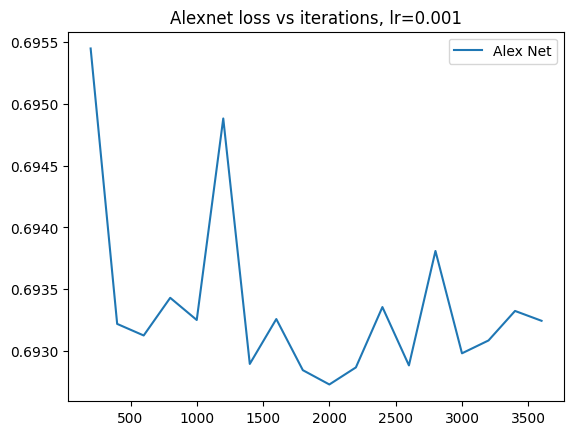

In [13]:
# Plotting generator and discriminator loss vs iterations
plt.plot(iter_list, an_loss_list, label="Alex Net")
plt.title(f"Alexnet loss vs iterations, lr={my_lr}")
plt.legend()
plt.show()

# Testing the Model

In [14]:
import sklearn.metrics as metrics

In [15]:
epoch = 4
my_lr = my_lr

model = Alexnet().to(device)
model.load_state_dict(torch.load(f"an_model_weights_{epoch}_{my_lr}.pth", weights_only=True))

<All keys matched successfully>

In [16]:
model.eval()

Alexnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=14400, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [17]:
def results_list(model, dataloader, device="cpu"):
    pred_results = []
    true_results = []
    
    for data, labels in tqdm(dataloader):
        images = data.to(device)
        results = model(images)
        
        for i in range(len(data)):
            pred_results.append(results[i].detach().clone())
            true_results.append(labels[i].detach().clone())
    
    return pred_results, true_results

In [18]:
pred, truth = results_list(model, train_dataloader, device) 

100%|██████████| 189/189 [01:34<00:00,  2.01it/s]


In [19]:
for i in range(len(pred)):
    if pred[i] >.5:
        pred[i] = 1
    else:
        pred[i] = 0

In [20]:
pred = torch.tensor(pred, device="cpu")

In [21]:
metrics.accuracy_score(pred, truth)

0.4998753842319515

# OLD - We will need to modify if we would like to keep these.

In [22]:
test_image = Image.open(data_path)

NameError: name 'data_path' is not defined

In [ ]:
transformed_test_image = transforms_augmented(test_image)
v2.ToPILImage(transformed_test_image)

# convert from (C, H, W) to (H, W, C) for displaying in matplotlib
img_np = transformed_test_image.permute(1, 2, 0).numpy()

# display augmented image
plt.imshow(img_np)
plt.axis('off')
plt.show()